In [1]:
import os
import pandas as pd
import numpy as np
import pandas_profiling
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
sns.set()
%matplotlib inline

jatdf = pd.read_csv('Sericulture  DATA1.csv')
#jatdf.describe(include='all').T

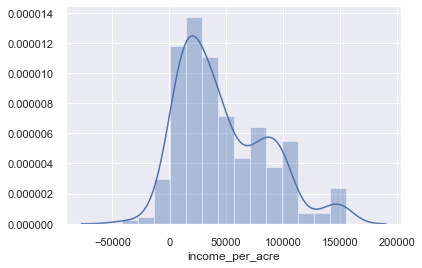

In [2]:
sns.distplot(jatdf['income_per_acre'])

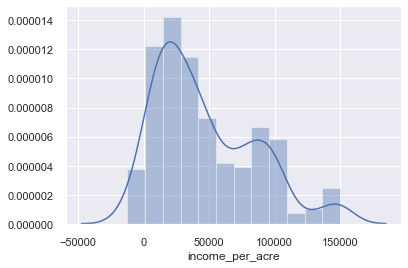

In [3]:
def outliers_capping(x,feature_name):
    x= x.clip(upper = x[feature_name].quantile(0.99))
    print(x.shape)
    x= x.clip(lower = x[feature_name].quantile(0.01))
    print(x.shape)
    return x
def outliers_capping(x):
    x= x.clip(upper = x.quantile(0.99))
    x= x.clip(lower = x.quantile(0.01))
    return x

jatdfclippedoutliers = jatdf.apply(lambda x: outliers_capping(x))
sns.distplot(jatdfclippedoutliers['income_per_acre'])

## Scatter plot between Income Per Acre and Training on Sericuluture

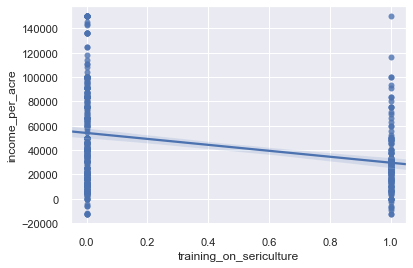

In [4]:
sns.regplot(x='training_on_sericulture',y='income_per_acre',data=jatdfclippedoutliers[['training_on_sericulture','income_per_acre']])

## Simple Linear Regression between Income per acre and Training on Sericulture

In [5]:
import statsmodels.api as sm

Y=jatdfclippedoutliers['income_per_acre']
X = jatdfclippedoutliers['training_on_sericulture']

from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(X,Y, train_size=0.8, test_size=0.2,random_state=100)

print(type(train_X))
jat_lm_model_1 = sm.OLS(train_y, sm.add_constant(train_X)).fit()
jat_lm_model_1.summary2()

<class 'pandas.core.series.Series'>


/Applications/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Ordinary least squares
====================================================================================
Model:                     OLS                   Adj. R-squared:          0.083     
Dependent Variable:        income_per_acre       AIC:                     9678.1726 
Date:                      2019-10-08 13:12      BIC:                     9686.1853 
No. Observations:          406                   Log-Likelihood:          -4837.1   
Df Model:                  1                     F-statistic:             37.64     
Df Residuals:              404                   Prob (F-statistic):      2.03e-09  
R-squared:                 0.085                 Scale:                   1.3123e+09
------------------------------------------------------------------------------------
                           Coef.     Std.Err.    t    P>|t|     [0.025      0.975]  
------------------------------------------------------------------------------------
const                    53135.3197 2134.6458 24.8919 0.0000  48938.9192  57331.7202
training_on_sericulture -24291.9795 3959.5683 -6.1350 0.0000 -32075.9099 -16508.0491
------------------------------------------------------------------------------------
Omnibus:                     25.003             Durbin-Watson:                1.931 
Prob(Omnibus):               0.000              Jarque-Bera (JB):             28.481
Skew:                        0.649              Prob(JB):                     0.000 
Kurtosis:                    2.991              Condition No.:                2     
====================================================================================

"""

In [6]:
jat_lm_model_1.params

const                      53135.319717
training_on_sericulture   -24291.979508
dtype: float64

## Test Of Normal Distribution of Residuals

<Figure size 576x432 with 0 Axes>

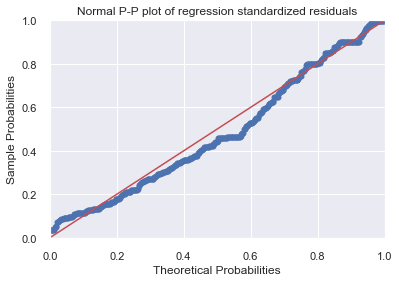

In [7]:
import matplotlib.pyplot as plt
import statsmodels.graphics.gofplots as sm

import seaborn as sn
%matplotlib inline

income_resid = jat_lm_model_1.resid
probplot = sm.ProbPlot(income_resid)
plt.figure(figsize = (8,6))
probplot.ppplot(line='45')
plt.title("Normal P-P plot of regression standardized residuals")
plt.show()

## Statistical Test for Normality

In [8]:
from scipy import stats

## Anderson Darling Test
print(stats.anderson(income_resid, dist='norm')) 

## Stat Test shows that residuals are not normal.

AndersonResult(statistic=4.135331253842082, critical_values=array([0.57 , 0.65 , 0.779, 0.909, 1.082]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))


## Test of Homoscedasticity

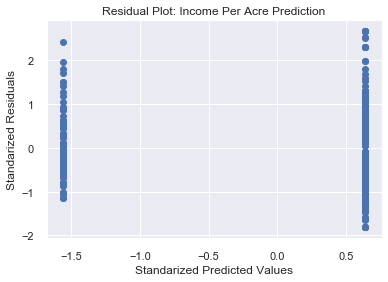

In [9]:
def get_standardized_values(vals):
    return (vals-vals.mean())/vals.std()


plt.scatter(get_standardized_values(jat_lm_model_1.fittedvalues),get_standardized_values(income_resid))
plt.title("Residual Plot: Income Per Acre Prediction");
plt.xlabel("Standarized Predicted Values")
plt.ylabel("Standarized Residuals");


## Including all variables except humidity_mgmt and rearing_cost_missing in the model

In [10]:
X = jatdfclippedoutliers[jatdfclippedoutliers.columns.difference(['humidity_mgmt','rearing_cost_missing'])]

Text(0.5, 1, 'Correlation Heatmap depicting correlation between features and outcome variable')

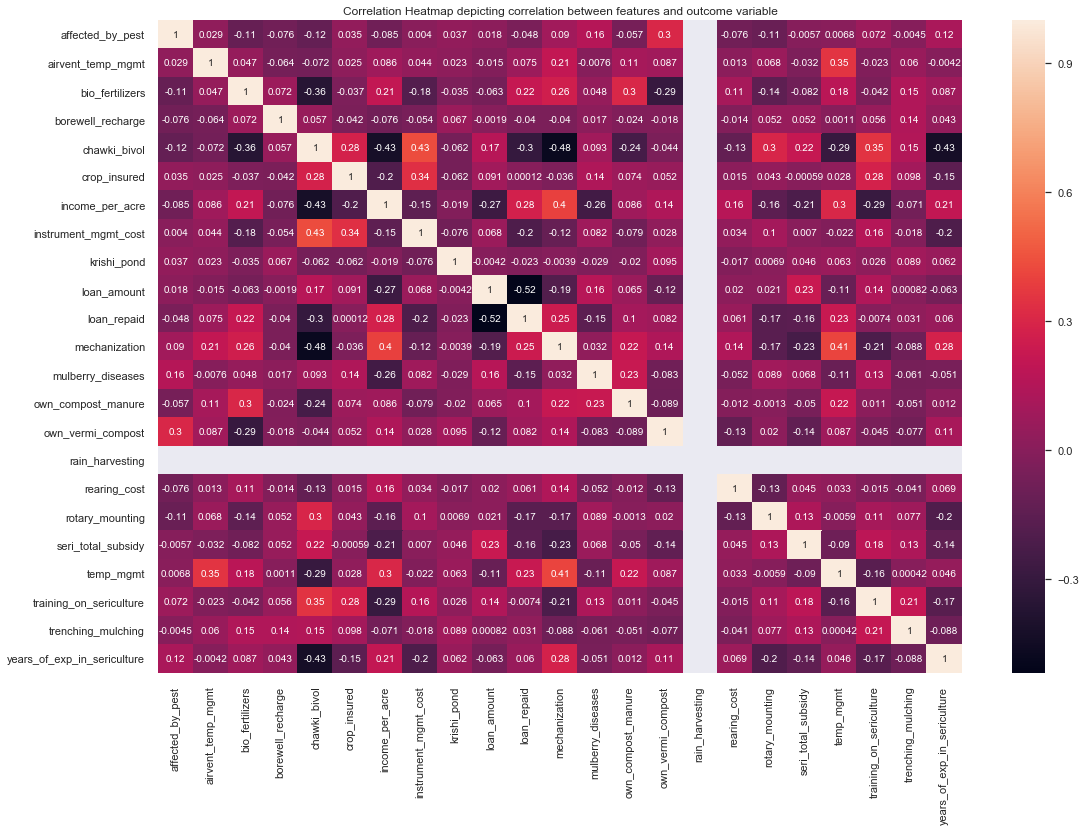

In [11]:
plt.figure(figsize=(18,12))
sns.heatmap(X.corr(),annot=True)
plt.title('Correlation Heatmap depicting correlation between features and outcome variable')

## Scaling Dependent (X) and Independent Features (Y)

In [12]:
X = jatdfclippedoutliers[jatdfclippedoutliers.columns.difference(['humidity_mgmt','rearing_cost_missing','income_per_acre','rain_harvesting','trenching_mulching'])]
Y = jatdfclippedoutliers['income_per_acre']

from sklearn.preprocessing import StandardScaler

X_scaler = StandardScaler()

X_scaled = X_scaler.fit_transform(X)

Y = (Y - Y.mean())/Y.std()

from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(X_scaled,Y, train_size=0.8, test_size=0.2,random_state=42)


In [13]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
linreg.fit(train_X, train_y)

beta_coeff_df = pd.DataFrame({'columns':X.columns,'coef':linreg.coef_})

sorted_coef_vals = beta_coeff_df.sort_values('coef',ascending=False)
sorted_coef_vals

,columns,coef
10,mechanization,0.184835
13,own_vermi_compost,0.136095
14,rearing_cost,0.098276
17,temp_mgmt,0.095627
2,bio_fertilizers,0.077549
6,instrument_mgmt_cost,0.044512
12,own_compost_manure,0.034109
9,loan_repaid,0.025545
19,years_of_exp_in_sericulture,0.019667
1,airvent_temp_mgmt,-0.007480


Text(0, 0.5, 'Features')

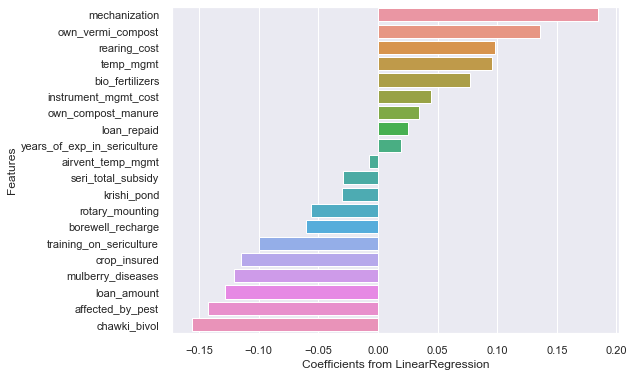

In [14]:
plt.figure(figsize = (8,6))
sns.barplot(x='coef',y='columns', data = sorted_coef_vals);
plt.xlabel("Coefficients from LinearRegression")
plt.ylabel("Features")

## Calculating Metrics of the Model - RMSE and R-Square

In [15]:
from sklearn import metrics

train_y_pred = linreg.predict(train_X)
test_y_pred = linreg.predict(test_X)

print("RMSE Train: ",round(np.sqrt(metrics.mean_squared_error(train_y, train_y_pred)),3),"Test: ", round(np.sqrt(metrics.mean_squared_error(test_y, test_y_pred)),3))

print("R^2 Train: %.3f, test: %.3f" % (metrics.r2_score(train_y, train_y_pred),metrics.r2_score(test_y, test_y_pred)))


RMSE Train:  0.791 Test:  0.803
R^2 Train: 0.378, test: 0.332


In [16]:
linreg_coef_df = pd.DataFrame({'columns':X.columns,'coef':linreg.coef_})
linreg_coef_df[linreg_coef_df.coef == 0]

,columns,coef


## Applying LASSO Regression for Feature Selection

In [17]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha = 0.1, max_iter = 1000)
lasso.fit(train_X,train_y)

train_y_pred = lasso.predict(train_X)
test_y_pred = lasso.predict(test_X)

print("RMSE Train: ",round(np.sqrt(metrics.mean_squared_error(train_y, train_y_pred)),3),"Test: ", round(np.sqrt(metrics.mean_squared_error(test_y, test_y_pred)),3))

print("R^2 Train: %.3f, test: %.3f" % (metrics.r2_score(train_y, train_y_pred),metrics.r2_score(test_y, test_y_pred)))



RMSE Train:  0.837 Test:  0.829
R^2 Train: 0.302, test: 0.288


In [18]:
lasso_coef_df = pd.DataFrame({'columns':X.columns,'coef':lasso.coef_})
lasso_coef_df[lasso_coef_df.coef == 0]
#['airvent_temp_mgmt','borewell_recharge','instrument_mgmt_cost','krishi_pond','own_compost_manure','own_vermi_compost','rotary_mounting','years_of_exp_in_sericulture']

,columns,coef
1,airvent_temp_mgmt,0.0
2,bio_fertilizers,0.0
3,borewell_recharge,-0.0
6,instrument_mgmt_cost,-0.0
7,krishi_pond,-0.0
12,own_compost_manure,0.0
13,own_vermi_compost,0.0
15,rotary_mounting,-0.0
16,seri_total_subsidy,-0.0
19,years_of_exp_in_sericulture,0.0


In [19]:


lasso_coef_df_vals = lasso_coef_df.sort_values('coef',ascending=False)
lasso_coef_df_vals

,columns,coef
10,mechanization,0.182616
17,temp_mgmt,0.044367
9,loan_repaid,0.011807
14,rearing_cost,0.008383
16,seri_total_subsidy,-0.000000
15,rotary_mounting,-0.000000
13,own_vermi_compost,0.000000
12,own_compost_manure,0.000000
1,airvent_temp_mgmt,0.000000
19,years_of_exp_in_sericulture,0.000000


## Using OLS Model without Transformation

In [20]:
X = jatdfclippedoutliers[jatdfclippedoutliers.columns.difference(['humidity_mgmt',
                                                                  'rearing_cost_missing','income_per_acre',
                                                                  'rain_harvesting','trenching_mulching'])]

X = jatdfclippedoutliers[['mechanization','temp_mgmt','rearing_cost','affected_by_pest',
    'loan_amount','mulberry_diseases','chawki_bivol','training_on_sericulture','own_vermi_compost']]



Y = jatdfclippedoutliers['income_per_acre']

from sklearn.model_selection import train_test_split


train_X, test_X, train_y, test_y = train_test_split(X,Y, train_size=0.8, test_size=0.2,random_state=42)

jat_lm_model_ols1 = sm.OLS(train_y, sm.add_constant(train_X)).fit()

jat_lm_model_ols1.summary()


/Applications/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        income_per_acre   R-squared:                       0.355
Model:                            OLS   Adj. R-squared:                  0.340
Method:                 Least Squares   F-statistic:                     24.17
Date:                Tue, 08 Oct 2019   Prob (F-statistic):           6.02e-33
Time:                        13:12:42   Log-Likelihood:                -4773.5
No. Observations:                 406   AIC:                             9567.
Df Residuals:                     396   BIC:                             9607.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     4.46e+04   6565.404      6.793      0.000    3.17e+04    5.75e+04
mechanization            1.697e+04   4163.931      4.076      0.000    8787.341    2.52e+04
temp_mgmt                1.025e+04   5170.849      1.982      0.048      84.350    2.04e+04
rearing_cost                0.1753      0.076      2.314      0.021       0.026       0.324
affected_by_pest        -1.165e+04   3408.426     -3.419      0.001   -1.84e+04   -4952.260
loan_amount                -0.0848      0.024     -3.529      0.000      -0.132      -0.038
mulberry_diseases       -1.052e+04   3559.737     -2.956      0.003   -1.75e+04   -3524.779
chawki_bivol            -1.925e+04   4189.745     -4.595      0.000   -2.75e+04    -1.1e+04
training_on_sericulture -9390.1711   3658.466     -2.567      0.011   -1.66e+04   -2197.728
own_vermi_compost        9928.4692   4669.969      2.126      0.034     747.437    1.91e+04
==============================================================================
Omnibus:                       11.379   Durbin-Watson:                   2.035
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               11.591
Skew:                           0.407   Prob(JB):                      0.00304
Kurtosis:                       3.145   Cond. No.                     4.36e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.36e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

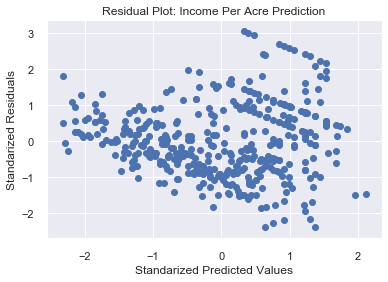

In [21]:
def get_standardized_values(vals):
    return (vals-vals.mean())/vals.std()

y_resid = jat_lm_model_ols1.resid
y_pred = jat_lm_model_ols1.fittedvalues

plt.scatter(get_standardized_values(y_pred),get_standardized_values(y_resid))
plt.title("Residual Plot: Income Per Acre Prediction");
plt.xlabel("Standarized Predicted Values")
plt.ylabel("Standarized Residuals");


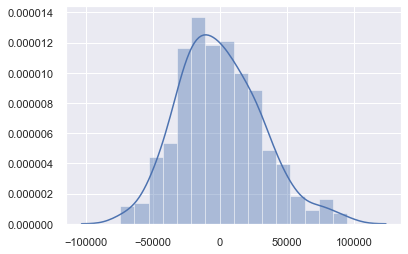

In [22]:
sns.distplot(y_resid)

## Using OLS Model with Yeo-Johnson Transformation

In [23]:
X = jatdfclippedoutliers[jatdfclippedoutliers.columns.difference(['humidity_mgmt','rearing_cost_missing','income_per_acre','rain_harvesting','trenching_mulching'])]

#X = jatdfclippedoutliers[['mechanization','temp_mgmt','bio_fertilizers',
#    'loan_amount','mulberry_diseases','chawki_bivol','training_on_sericulture','own_vermi_compost']]

X = jatdfclippedoutliers[['mechanization','temp_mgmt','rearing_cost','affected_by_pest',
    'loan_amount','mulberry_diseases','chawki_bivol','training_on_sericulture','own_vermi_compost']]

Y = jatdfclippedoutliers['income_per_acre']

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer

#X_scaler = StandardScaler()

#X_scaled = X_scaler.fit_transform(X)

#Y = (Y - Y.mean())/Y.std()

from sklearn.model_selection import train_test_split


train_X, test_X, train_y, test_y = train_test_split(X,Y, train_size=0.8, test_size=0.2,random_state=42)

train_y= train_y.to_numpy().reshape(-1, 1)
test_y= test_y.to_numpy().reshape(-1, 1)
#x_test = x_test.reshape(-1, 1)

pt = PowerTransformer()
pt.fit(train_X)                       
train_X_trans = pt.transform(train_X)
test_X_trans = pt.transform(test_X)

pt_y = PowerTransformer()
pt_y.fit(train_y)


 
train_y_trans = pt_y.transform(train_y)
test_y_trans = pt_y.transform(test_y)


jat_lm_model_ols1 = sm.OLS(train_y_trans, sm.add_constant(train_X_trans)).fit()

jat_lm_model_ols1.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.346
Model:                            OLS   Adj. R-squared:                  0.331
Method:                 Least Squares   F-statistic:                     23.25
Date:                Tue, 08 Oct 2019   Prob (F-statistic):           8.25e-32
Time:                        13:12:43   Log-Likelihood:                -489.99
No. Observations:                 406   AIC:                             1000.
Df Residuals:                     396   BIC:                             1040.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.978e-16      0.041  -4.87e-15      1.000      -0.080       0.080
x1             0.2124      0.051      4.151      0.000       0.112       0.313
x2             0.1076      0.046      2.340      0.020       0.017       0.198
x3             0.0807      0.042      1.929      0.054      -0.002       0.163
x4            -0.1528      0.044     -3.444      0.001      -0.240      -0.066
x5            -0.1486      0.046     -3.197      0.002      -0.240      -0.057
x6            -0.1181      0.044     -2.695      0.007      -0.204      -0.032
x7            -0.1832      0.051     -3.571      0.000      -0.284      -0.082
x8            -0.0936      0.044     -2.132      0.034      -0.180      -0.007
x9             0.1039      0.045      2.321      0.021       0.016       0.192
==============================================================================
Omnibus:                        1.768   Durbin-Watson:                   2.044
Prob(Omnibus):                  0.413   Jarque-Bera (JB):                1.578
Skew:                           0.076   Prob(JB):                        0.454
Kurtosis:                       3.265   Cond. No.                         2.39
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [24]:
X = jatdfclippedoutliers[jatdfclippedoutliers.columns.difference(['humidity_mgmt','rearing_cost_missing','income_per_acre','rain_harvesting','trenching_mulching'])]

#X = jatdfclippedoutliers[['mechanization','temp_mgmt','bio_fertilizers',
#    'loan_amount','mulberry_diseases','chawki_bivol','training_on_sericulture','own_vermi_compost']]

X = jatdfclippedoutliers[['mechanization','temp_mgmt','affected_by_pest',
    'loan_amount','mulberry_diseases','chawki_bivol','training_on_sericulture','own_vermi_compost']]



Y = jatdfclippedoutliers['income_per_acre']

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer

#X_scaler = StandardScaler()

#X_scaled = X_scaler.fit_transform(X)

#Y = (Y - Y.mean())/Y.std()

from sklearn.model_selection import train_test_split


train_X, test_X, train_y, test_y = train_test_split(X,Y, train_size=0.8, test_size=0.2,random_state=42)

train_y= train_y.to_numpy().reshape(-1, 1)
test_y= test_y.to_numpy().reshape(-1, 1)
#x_test = x_test.reshape(-1, 1)

pt = PowerTransformer()
pt.fit(train_X)                       
train_X_trans = pt.transform(train_X)
test_X_trans = pt.transform(test_X)

pt_y = PowerTransformer()
pt_y.fit(train_y)


 
train_y_trans = pt_y.transform(train_y)
test_y_trans = pt_y.transform(test_y)


jat_lm_model_ols1 = sm.OLS(train_y_trans, sm.add_constant(train_X_trans)).fit()

jat_lm_model_ols1.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.340
Model:                            OLS   Adj. R-squared:                  0.326
Method:                 Least Squares   F-statistic:                     25.51
Date:                Tue, 08 Oct 2019   Prob (F-statistic):           9.43e-32
Time:                        13:12:44   Log-Likelihood:                -491.88
No. Observations:                 406   AIC:                             1002.
Df Residuals:                     397   BIC:                             1038.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.978e-16      0.041  -4.85e-15      1.000      -0.080       0.080
x1             0.2251      0.051      4.420      0.000       0.125       0.325
x2             0.1038      0.046      2.252      0.025       0.013       0.194
x3            -0.1564      0.044     -3.514      0.000      -0.244      -0.069
x4            -0.1491      0.047     -3.196      0.002      -0.241      -0.057
x5            -0.1255      0.044     -2.864      0.004      -0.212      -0.039
x6            -0.1908      0.051     -3.717      0.000      -0.292      -0.090
x7            -0.0895      0.044     -2.034      0.043      -0.176      -0.003
x8             0.0943      0.045      2.112      0.035       0.007       0.182
==============================================================================
Omnibus:                        2.655   Durbin-Watson:                   2.052
Prob(Omnibus):                  0.265   Jarque-Bera (JB):                2.850
Skew:                           0.007   Prob(JB):                        0.240
Kurtosis:                       3.410   Cond. No.                         2.37
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

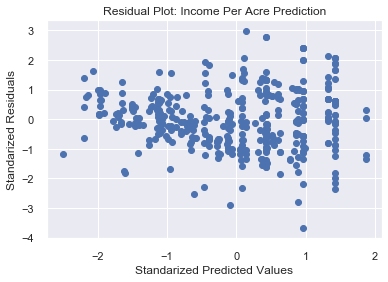

In [25]:
def get_standardized_values(vals):
    return (vals-vals.mean())/vals.std()

y_resid = jat_lm_model_ols1.resid
y_pred = jat_lm_model_ols1.fittedvalues

plt.scatter(get_standardized_values(y_pred),get_standardized_values(y_resid))
plt.title("Residual Plot: Income Per Acre Prediction");
plt.xlabel("Standarized Predicted Values")
plt.ylabel("Standarized Residuals");


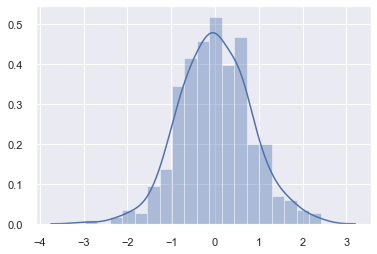

In [26]:
sns.distplot(y_resid)

## 5.3 Missing Value Treatment for rearing_cost_missing

In [37]:
jatdfclippedoutliers[['rearing_cost_missing']].info()
#jatdfclippedoutliers[jatdfclippedoutliers['rearing_cost_missing'].isnull()]

jatdfclippedoutliers.iloc[[21,23,52,125,146,166,207,230,231,268,280,290,344,400,448,453,457,477,484,486]]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 508 entries, 0 to 507
Data columns (total 1 columns):
rearing_cost_missing    488 non-null float64
dtypes: float64(1)
memory usage: 4.0 KB


,loan_amount,loan_repaid,crop_insured,years_of_exp_in_sericulture,training_on_sericulture,krishi_pond,borewell_recharge,rain_harvesting,own_compost_manure,own_vermi_compost,...,rearing_cost,instrument_mgmt_cost,temp_mgmt,humidity_mgmt,airvent_temp_mgmt,rotary_mounting,seri_total_subsidy,income_per_acre,chawki_bivol,rearing_cost_missing
21,60000.0,1,0,2,1,1,0,0,0,0,...,40000.0,0,1,1,1,0,95090.0,-7692.307692,1,NaN
23,200000.0,1,0,20,0,0,0,0,0,0,...,80000.0,0,0,0,0,0,41000.0,40000.000000,1,NaN
52,35000.0,1,1,8,1,0,0,0,1,0,...,60000.0,20000,1,1,1,0,85200.0,33333.333330,1,NaN
125,0.0,1,0,6,0,0,0,0,1,0,...,25000.0,6000,1,1,1,0,0.0,62500.000000,0,NaN
146,200000.0,0,0,15,0,0,0,0,1,0,...,20000.0,2000,1,1,1,0,35000.0,40322.580650,0,NaN
166,0.0,1,0,10,0,0,0,0,1,0,...,55000.0,2000,1,1,1,0,0.0,75000.000000,0,NaN
207,0.0,1,0,5,0,0,0,0,1,0,...,40000.0,2000,1,1,1,0,0.0,100000.000000,0,NaN
230,250000.0,0,0,20,0,0,0,0,1,0,...,25000.0,1000,1,1,1,0,35000.0,16666.666670,0,NaN
231,0.0,1,0,20,0,0,0,0,0,0,...,40000.0,2000,1,1,1,0,0.0,66666.666670,0,NaN
268,40000.0,0,0,2,0,0,0,0,0,0,...,40000.0,10000,1,1,1,1,0.0,45454.545450,1,NaN


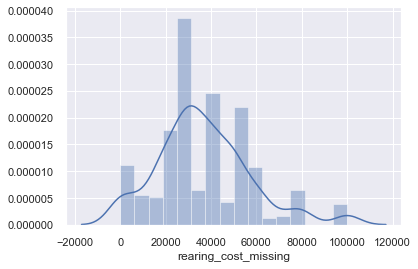

In [28]:
df_rearing_cost_not_missing = jatdfclippedoutliers[jatdfclippedoutliers['rearing_cost_missing'].notnull()]

sns.distplot(df_rearing_cost_not_missing['rearing_cost_missing'])

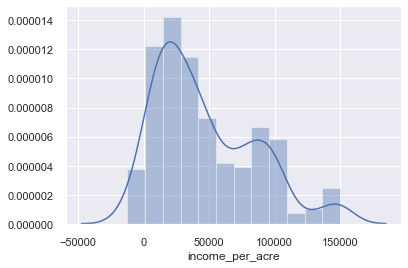

In [32]:
jatdfclippedoutliers = jatdf.apply(lambda x: outliers_capping(x))
sns.distplot(jatdfclippedoutliers['income_per_acre'])

## Missing Value Imputation

In [84]:
from missingpy import KNNImputer
imputer = KNNImputer()
#X_imputed = imputer.fit_transform(X)

In [85]:
#from autoimpute.imputations import SingleImputer, MultipleImputer

In [87]:
#from sklearn.experimental import enable_iterative_imputer

X = jatdfclippedoutliers[jatdfclippedoutliers.columns.difference(['humidity_mgmt','rearing_cost','income_per_acre','rain_harvesting','trenching_mulching'])]

#X = jatdfclippedoutliers[['mechanization','temp_mgmt','bio_fertilizers',
#    'loan_amount','mulberry_diseases','chawki_bivol','training_on_sericulture','own_vermi_compost']]

X = jatdfclippedoutliers[['mechanization','temp_mgmt','rearing_cost_missing','affected_by_pest',
    'loan_amount','mulberry_diseases','chawki_bivol','training_on_sericulture','own_vermi_compost']]



Y = jatdfclippedoutliers['income_per_acre']

from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split
#from sklearn.impute import IterativeImputer



train_X, test_X, train_y, test_y = train_test_split(X,Y, train_size=0.8, test_size=0.2,random_state=42)


print(train_X[train_X['rearing_cost_missing'].isnull()])

#print(train_X.iloc[[21,23,52,125,146,166,207,230,231,268,280,290,344,400,448,453,457,477,484,486]])
from missingpy import KNNImputer
imputer = KNNImputer()
imputer.fit(train_X)

#imputer = MultipleImputer()
train_X = imputer.fit_transform(train_X)
#train_X = imputer.transform(train_X)
test_X = imputer.fit_transform(test_X)

#iterImp = IterativeImputer(max_iter=10, random_state=0)
#iterImp.fit(train_X)
#train_X = iterImp.transform(train_X)
#test_X = iterImp.transform(test_X)


#train_y= train_y.to_numpy().reshape(-1, 1)
#test_y= test_y.to_numpy().reshape(-1, 1)

#pt = PowerTransformer()
#pt.fit(train_X)                       
#train_X_trans = pt.transform(train_X)
#test_X_trans = pt.transform(test_X)

#pt_y = PowerTransformer()
#pt_y.fit(train_y)


 
#train_y_trans = pt_y.transform(train_y)
#test_y_trans = pt_y.transform(test_y)


jat_lm_model_ols1 = sm.OLS(train_y, sm.add_constant(train_X)).fit()

df = pd.DataFrame(data=np.int_(train_X[1:,0:]),index=train_X[1:,0], columns=X.columns)
df.reset_index(inplace=True)
#print(df[['rearing_cost_missing']].info())

#print(df.iloc[[21,23,52,125,146,166,207,230,231,268,280,290,344,400,448,453,457,477,484,486]])

jat_lm_model_ols1.summary()
#df.iloc[[21,23,52,125,146,166,207,230,231,268,280,290,344,400,448,453,457,477,484,486]]
#df = pd.DataFrame(data=train_X[1:,1:],index=train_X[1:,0], columns=train_X[0,1:])
#df = pd.DataFrame(data=train_X[1:,0:],index=train_X[1:,0], columns=X.columns)
#df.reset_index()
#df
#df.shape
#df.iloc[[21,23,52,125,146,166,207,230,231,268,280,290,344,400,448,453,457,477,484,486]]

     mechanization  temp_mgmt  rearing_cost_missing  affected_by_pest  \
486              1          1                   NaN                 0   
23               0          0                   NaN                 1   
477              1          1                   NaN                 1   
146              1          1                   NaN                 1   
290              1          1                   NaN                 0   
125              1          1                   NaN                 1   
453              1          1                   NaN                 0   
230              1          1                   NaN                 1   
484              1          1                   NaN                 0   
207              1          1                   NaN                 1   
448              1          1                   NaN                 0   
52               1          1                   NaN                 0   
166              1          1                   NaN

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:432: DeprecationWarning: 'warn_on_dtype' is deprecated in version 0.21 and will be removed in 0.23. Don't set `warn_on_dtype` to remove this warning.
  DeprecationWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:432: DeprecationWarning: 'warn_on_dtype' is deprecated in version 0.21 and will be removed in 0.23. Don't set `warn_on_dtype` to remove this warning.
  DeprecationWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:432: DeprecationWarning: 'warn_on_dtype' is deprecated in version 0.21 and will be removed in 0.23. Don't set `warn_on_dtype` to remove this warning.
  DeprecationWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:432: DeprecationWarning: 'warn_on_dtype' is deprecated in version 0.21 and will be removed in 0.23. Don't set `warn_on_dtype` to remove this warning.
  DeprecationW

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        income_per_acre   R-squared:                       0.353
Model:                            OLS   Adj. R-squared:                  0.338
Method:                 Least Squares   F-statistic:                     24.02
Date:                Tue, 08 Oct 2019   Prob (F-statistic):           9.07e-33
Time:                        19:34:17   Log-Likelihood:                -4773.9
No. Observations:                 406   AIC:                             9568.
Df Residuals:                     396   BIC:                             9608.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.526e+04   6556.900      6.902      0.000    3.24e+04    5.81e+04
x1          1.705e+04   4170.005      4.088      0.000    8848.165    2.52e+04
x2          1.008e+04   5174.558      1.949      0.052     -90.189    2.03e+04
x3             0.1648      0.078      2.121      0.035       0.012       0.318
x4         -1.183e+04   3408.223     -3.471      0.001   -1.85e+04   -5129.664
x5            -0.0851      0.024     -3.533      0.000      -0.132      -0.038
x6         -1.054e+04   3565.428     -2.957      0.003   -1.76e+04   -3532.122
x7         -1.926e+04   4195.964     -4.591      0.000   -2.75e+04    -1.1e+04
x8         -9421.7852   3664.116     -2.571      0.010   -1.66e+04   -2218.234
x9          9879.9991   4678.070      2.112      0.035     683.042    1.91e+04
==============================================================================
Omnibus:                       11.140   Durbin-Watson:                   2.038
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               11.330
Skew:                           0.403   Prob(JB):                      0.00347
Kurtosis:                       3.141   Cond. No.                     4.35e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.35e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
jat_lm_model_ols1.params

In [ ]:
train_X_inverse_transformed = iterImp.inverse_transform(train_X)
train_X_inverse_transformed

#sns.distplot(train_X['rearing_cost_missing'])

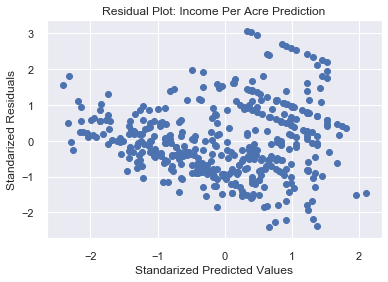

In [65]:
def get_standardized_values(vals):
    return (vals-vals.mean())/vals.std()

y_resid = jat_lm_model_ols1.resid
y_pred = jat_lm_model_ols1.fittedvalues

plt.scatter(get_standardized_values(y_pred),get_standardized_values(y_resid))
plt.title("Residual Plot: Income Per Acre Prediction");
plt.xlabel("Standarized Predicted Values")
plt.ylabel("Standarized Residuals");